## 이상값 식별
- 연속변수의 분포를 파악한 후 -> 이상값인지 판단
- 즉, 변수의 분포를 이해하는 것이 먼저
- 중심경향성과 분포의 형태를 조사해 측도(measure)를 생성 -> 정규성(nomality) 시각화

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as scistat

covidtotals=pd.read_csv('C:/data-cleansing-main/Chapter04/data/covidtotals.csv')
covidtotals.set_index('iso_code',inplace=True)
totvars = ['location','total_cases','total_deaths','total_cases_pm','total_deaths_pm']
demovars = ['population','pop_density','median_age','gdp_per_capita','hosp_beds']

In [7]:
covidtotalsonly=covidtotals.loc[:,totvars]
covidtotalsonly.describe()                      # 주요 사례 데이터만으로 데이터프레임 생성

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
count,2.100000e+02,210.000000,210.000000,210.000000
mean,2.921614e+04,1770.714286,1355.357943,55.659129
std,1.363978e+05,8705.565857,2625.277497,144.785816
min,0.000000e+00,0.000000,0.000000,0.000000
25%,1.757500e+02,4.000000,92.541500,0.884750
50%,1.242500e+03,25.500000,280.928500,6.154000
75%,1.011700e+04,241.250000,1801.394750,31.777250
max,1.790191e+06,104383.000000,19771.348000,1237.551000


### 좀 더 자세한 백분위수 데이터 표시 -> 왜도, 첨도
1. 왜도(skewness): 대칭의 정도, 오른쪽으로 꼬리가 길 수록 왜도는 양수

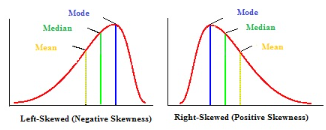

2. 첨도(kurtosis): 분포의 꼬리 부분의 길이, 중앙부의 뾰족함 정도

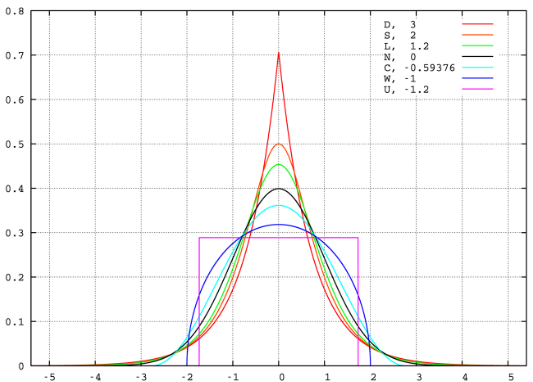

In [8]:
covidtotalsonly.quantile(np.arange(0.0,1.1,0.1))

C:\Users\victo\AppData\Local\Temp\ipykernel_36328\954660610.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  covidtotalsonly.quantile(np.arange(0.0,1.1,0.1))


,total_cases,total_deaths,total_cases_pm,total_deaths_pm
0.0,0.0,0.0,0.0000,0.0000
0.1,22.9,0.0,17.9986,0.0000
0.2,105.2,2.0,56.2910,0.3752
0.3,302.0,6.7,115.4341,1.7183
0.4,762.0,12.0,213.9734,3.9566
0.5,1242.5,25.5,280.9285,6.1540
0.6,2514.6,54.6,543.9562,12.2452
0.7,6959.8,137.2,1071.2442,25.9459
0.8,16847.2,323.2,2206.2982,49.9658
0.9,46513.1,1616.9,3765.1363,138.9045


In [9]:
# 왜도
covidtotalsonly.skew()          # total_cases는 꼬리가 오른쪽으로 긴건가?

C:\Users\victo\AppData\Local\Temp\ipykernel_36328\826569919.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  covidtotalsonly.skew()


total_cases        10.804275
total_deaths        8.929816
total_cases_pm      4.396091
total_deaths_pm     4.674417
dtype: float64

In [10]:
# 첨도
covidtotalsonly.kurtosis()

C:\Users\victo\AppData\Local\Temp\ipykernel_36328\2848359957.py:1: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  covidtotalsonly.kurtosis()


total_cases        134.979577
total_deaths        95.737841
total_cases_pm      25.242790
total_deaths_pm     27.238232
dtype: float64

### 정규성 검정
- scipy 라이브러리의 샤피로 윌크 검정 사용
- p값 0.05 미만에서 정규분포의 귀무가설 기각 가능

In [13]:
# 코로나19 데이터의 정규성 검정
def testnorm(var,df):
    stat,p=scistat.shapiro(df[var])
    return p

print(testnorm('total_cases',covidtotalsonly))
print(testnorm('total_deaths',covidtotalsonly))
print(testnorm('total_cases_pm',covidtotalsonly))
print(testnorm('total_deaths_pm',covidtotalsonly))

3.753789128593843e-29
4.3427896631016077e-29
1.3972683006509067e-23
1.361060423265974e-25


Text(0.5, 1.0, 'QQ Plot of Total Cases')

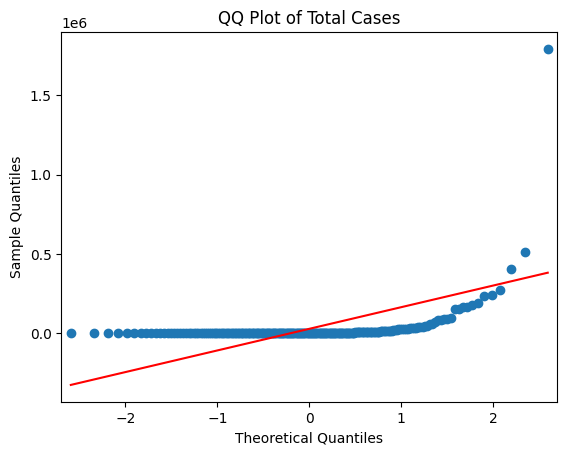

In [14]:
# 총확진자 수와 백만 명당 확진자 수의 정규 분위수 그림
sm.qqplot(covidtotalsonly[['total_cases']].sort_values(['total_cases']),line='s')
plt.title('QQ Plot of Total Cases')

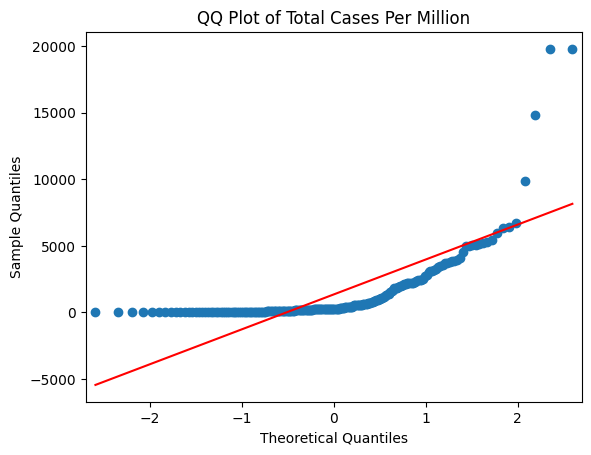

In [15]:
sm.qqplot(covidtotals[['total_cases_pm']].sort_values(['total_cases_pm']),line='s')
plt.title('QQ Plot of Total Cases Per Million')

plt.show()

- 직선은 분포가 정규일 경우의 모습
- 정규분포와 크게 다르다.

### 이상값 범위 나타내기
- 사분위범위: 제 1사분위수 <-> 제 3사분위수
- 사분위범위의 1.5배가 넘는 거리에 있는 값을 이상값으로 판단

In [16]:
thirdq, firstq = covidtotalsonly.total_cases.quantile(0.75), covidtotalsonly.total_cases.quantile(0.25)
interquartilerange = 1.5*(thirdq-firstq)
outlierhigh, outlierlow = interquartilerange+thirdq, firstq-interquartilerange
print(outlierlow, outlierhigh, sep=" <--> ")

# 이상값의 데이터프레임을 생성
def getoutliers():
  dfout = pd.DataFrame(columns=covidtotals.columns, data=None)
  for col in covidtotalsonly.columns[1:]:
    thirdq, firstq = covidtotalsonly[col].quantile(0.75),\
      covidtotalsonly[col].quantile(0.25)
    interquartilerange = 1.5*(thirdq-firstq)
    outlierhigh, outlierlow = interquartilerange+thirdq,\
      firstq-interquartilerange
    df = covidtotals.loc[(covidtotals[col]>outlierhigh) | \
      (covidtotals[col]<outlierlow)]
    df = df.assign(varname = col, threshlow = outlierlow,\
       threshhigh = outlierhigh)
    dfout = pd.concat([dfout, df])
  return dfout

-14736.125 <--> 25028.875


In [19]:
outliers=getoutliers()
outliers.varname.value_counts()
outliers

,lastdate,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds,varname,threshlow,threshhigh
BGD,2020-06-01,Bangladesh,47153,650,286.315,3.947,164689383.0,1265.036,27.5,3523.984,0.80,total_cases,-14736.125,25028.875
BLR,2020-06-01,Belarus,42556,235,4503.604,24.870,9449321.0,46.858,40.3,17167.967,11.00,total_cases,-14736.125,25028.875
BEL,2020-06-01,Belgium,58381,9467,5037.354,816.852,11589616.0,375.564,41.8,42658.576,5.64,total_cases,-14736.125,25028.875
BRA,2020-06-01,Brazil,514849,29314,2422.142,137.910,212559409.0,25.040,33.5,14103.452,2.20,total_cases,-14736.125,25028.875
CAN,2020-06-01,Canada,90936,7295,2409.401,193.285,37742157.0,4.037,41.4,44017.591,2.50,total_cases,-14736.125,25028.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESP,2020-05-31,Spain,239429,27127,5120.952,580.197,46754783.0,93.105,45.5,34272.360,2.97,total_deaths_pm,-45.454,78.116
SWE,2020-06-01,Sweden,37542,4395,3717.298,435.180,10099270.0,24.718,41.0,46949.283,2.22,total_deaths_pm,-45.454,78.116
CHE,2020-06-01,Switzerland,30779,1656,3556.367,191.343,8654618.0,214.243,43.1,57410.166,4.53,total_deaths_pm,-45.454,78.116
GBR,2020-06-01,United Kingdom,274762,38489,4047.403,566.965,67886004.0,272.898,40.8,39753.244,2.54,total_deaths_pm,-45.454,78.116


In [18]:
# 백만 명당 확진자 수의 이상값 자세히 살펴보기
outliers.loc[outliers.varname=="total_cases_pm",['location','total_cases_pm','pop_density','gdp_per_capita']].sort_values(['total_cases_pm'], ascending=False)


,location,total_cases_pm,pop_density,gdp_per_capita
SMR,San Marino,19771.348,556.667,56861.470
QAT,Qatar,19753.146,227.322,116935.600
VAT,Vatican,14833.127,NaN,NaN
AND,Andorra,9888.048,163.755,NaN
BHR,Bahrain,6698.468,1935.907,43290.705
LUX,Luxembourg,6418.776,231.447,94277.965
KWT,Kuwait,6332.420,232.128,65530.537
SGP,Singapore,5962.727,7915.731,85535.383
USA,United States,5408.389,35.608,54225.446
ISL,Iceland,5292.308,3.404,46482.958


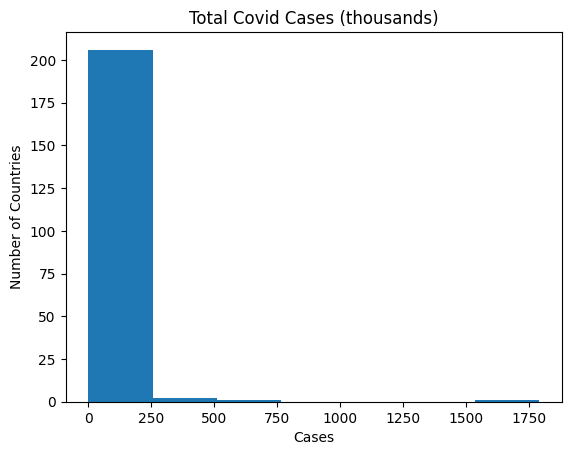

In [21]:
# 총 확진자 수의 히스토그램 표시
plt.hist(covidtotalsonly['total_cases']/1000,bins=7)
plt.title('Total Covid Cases (thousands)')
plt.xlabel('Cases')
plt.ylabel('Number of Countries')
plt.show()                                              # 로그 함수 형태(?)

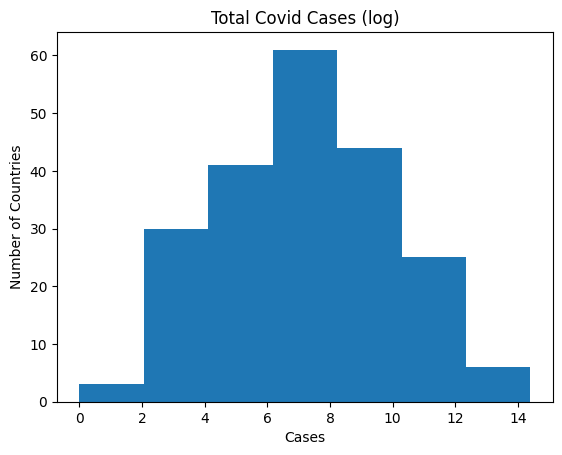

In [22]:
# 로그 변환
covidlogs=covidtotalsonly.copy()
for col in covidtotalsonly.columns[1:]:
    covidlogs[col]=np.log1p(covidlogs[col])

plt.hist(covidlogs['total_cases'],bins=7)
plt.title('Total Covid Cases (log)')
plt.xlabel('Cases')
plt.ylabel('Number of Countries')
plt.show()   

> covid 데이터 자체는 오류가 별로 없지만, 변수 분포가 통계적으로 문제가 있다.

- 무엇이 이상값을 구성하는가는 대부분 정규분포를 가정한다.
- 그러나 본질적으로 정규분포를 따르지 않는 데이터(사회적, 생물학적, 물리학적->균등, 로그, 지수, 포아송 등)를 다룰 때에는 감각을 조정해야 한다.

### 전체 과정 정리
* describe() -> quantile(np.arange(0.0, 1.1, 0.1)) -> 왜도, 첨도 -> 정규성 검정(shapiro) -> 정규 분위수 그림(qqplot) -> 사분위범위 -> 로그변환